- `Acesso aos dados`: [MCD19A2.061: Terra & Aqua MAIAC Land Aerosol Optical Depth Daily 1km ](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MCD19A2_GRANULES)
- `Período dos dados`: 2000-02-24T00:00:00Z–2024-05-16T23:55:00Z
- `Resolução espacial`: 1000 metros
- `Resolução temporal`: diária
- `Variável utilizada`: Aerosol optical depth over land retrieved in the MODIS Green band (0.55 μm)
- `Código realizado por`: Enrique V. Mattos - 13/04/2025

# **1° Passo:** Preparando ambiente

In [ ]:
# instalando bibliotecas
!pip install -q ultraplot cartopy salem rasterio

# iniciando GEE e instalando XEE (transforma dados do GEE para formato DataSet)
!pip install -q eemont xee
import ee, geemap
ee.Authenticate()
ee.Initialize(project='ee-enrique', opt_url='https://earthengine-highvolume.googleapis.com')

# importa bibliotecas
import numpy as np
import ultraplot as uplt
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
from zipfile import ZipFile
import salem
from datetime import datetime, timedelta
import glob
import xarray as xr
import os
import cartopy.crs as ccrs
import warnings
warnings.filterwarnings('ignore')

# monta drive
from google.colab import drive
drive.mount('/content/drive')

# caminho do drive
dir = '/content/drive/MyDrive/2-PESQUISA/artigo_queimadas_2024'

# leitura do shapefile do Brasil
shapefile_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/brasil/BRAZIL.shp')

# leitura do shapefile com a biblioteca SALEM
url = 'https://github.com/evmpython/shapefile/raw/main/'
shp = salem.read_shapefile(f'{url}itajuba/itajuba.shp')
itajuba = salem.read_shapefile(f'{url}itajuba/itajuba.shp')
mg = salem.read_shapefile(f'{url}estado_MG/MG_UF_2019.shp')

# limites do Brasil
lonmin_BR, lonmax_BR, latmin_BR, latmax_BR = -75.0, -33.0, -35.0, 7.0

# limites de MG
lonmin_MG, lonmax_MG, latmin_MG, latmax_MG = -52., -39., -23., -14.

# **PARTE 1):** Processamento

## 1) Mapa no GEE

In [ ]:
#========================================================================================================================#
#                                          FILTRA REGIÃO DE INTERESSE
#========================================================================================================================#
brasil = ee.FeatureCollection('FAO/GAUL/2015/level0').filter(ee.Filter.eq('ADM0_NAME', 'Brazil'))
estado_sp = ee.FeatureCollection('FAO/GAUL/2015/level1').filter(ee.Filter.eq('ADM1_NAME', 'Sao Paulo'))
municipio_itajuba = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(ee.Filter.eq('ADM2_NAME', 'Itajuba'))

#========================================================================================================================#
#                                            CARREGA OS DADOS
#========================================================================================================================#
# carrega os dados
AOD_055 = ee.ImageCollection('MODIS/061/MCD19A2_GRANULES') \
            .filter(ee.Filter.date('2024-08-01', '2024-09-01')) \
            .select('Optical_Depth_055') \
            .filterBounds(estado_sp)

#========================================================================================================================#
#                                           PLOTA FIGURA
#========================================================================================================================#
# cria a moldura do mapa
Map = geemap.Map()

# centraliza o mapa na região
Map.centerObject(estado_sp, zoom=6)

# parâmetros de visualização
vis = {'min': 0, 'max': 1, 'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']}

# plota mapa
Map.addLayer(AOD_055.max().clip(estado_sp).multiply(0.001), vis, 'AOD MODIS Green band (0.55 μm)')

# contorno da região
style1 = {'color': 'red', 'fillColor': '00000000'}
Map.addLayer(estado_sp.style(**style1), {}, 'MG')

# barra de cores
Map.add_colorbar_branca(colors=vis['palette'], vmin=vis['min'], vmax=vis['max'], layer_name='AOD MODIS Green band (0.55 μm)')

# exibe na tela
Map

In [ ]:
# mostra os dados
AOD_055

Em 1 mês de dados tem 2141 arquivos

In [ ]:
# transforma a data para o formato "ano-mes-dia hora:minuto" e extrai os valores
AOD_055_2 = AOD_055.map(lambda img: img.set( {"DATE": ee.Date(img.get("system:time_start")).format("YYYY-MM-dd hh:mm")}))

# agrega as informações
agrega = (AOD_055_2.aggregate_array("DATE").getInfo())

# mostra na tela
pd.DataFrame(agrega)

## 2) Produz arquivo netcdf
- Para processar 1 ano de dados, ou seja gerar um arquivo netcdf de um ano demora `5min 4s`

### - Teste para um ano

In [ ]:
%%time
# Define ano
ano = 2024

# Define diretório de saída
output_dir = f'{dir}/output/02_AOD_550nm/'

# Carrega apenas a região de interesse (otimizado)
estado_sp = ee.FeatureCollection('FAO/GAUL/2015/level1') \
              .filter(ee.Filter.eq('ADM1_NAME', 'Sao Paulo')) \
              .first()

# Define intervalo temporal
inicio_ano = ee.Date.fromYMD(ano, 1, 1)
fim_ano = inicio_ano.advance(1, 'year')
print('1. Definiu data inicial e final')

# Carrega e processa os dados diretamente (mais eficiente)
AOD_ano = ee.ImageCollection('MODIS/061/MCD19A2_GRANULES') \
            .filterBounds(estado_sp.geometry()) \
            .filterDate(inicio_ano, fim_ano) \
            .select('Optical_Depth_055') \
            .mean() \
            .multiply(0.001) \
            .clip(estado_sp) \
            .set({'system:time_start': inicio_ano.millis(), 'ano': str(ano)})
print('2. Carregou os dados')

# Converte para xarray Dataset (configuração otimizada)
ds = xr.open_dataset(AOD_ano,
                     engine='ee',
                     crs='EPSG:4326',
                     scale=0.20,
                     geometry=estado_sp.geometry())
print('3. Transformou para DataSet')

# Reorganiza dimensões
ds = ds.transpose("time", "lat", "lon")
print('4. Calculou a transposta')

# Nome do arquivo de saída
output_file = f'{output_dir}AOD_055_MODIS_mean_anual_{ano}_20km.nc'

# Exporta para NetCDF
ds.to_netcdf(output_file)
print(f'2. Arquivo exportado para netcdf com sucesso: {output_file}')

1. Definiu data inicial e final
2. Carregou os dados
3. Transformou para DataSet
4. Calculou a transposta


In [ ]:
ds

In [ ]:
ds.Optical_Depth_055.plot()

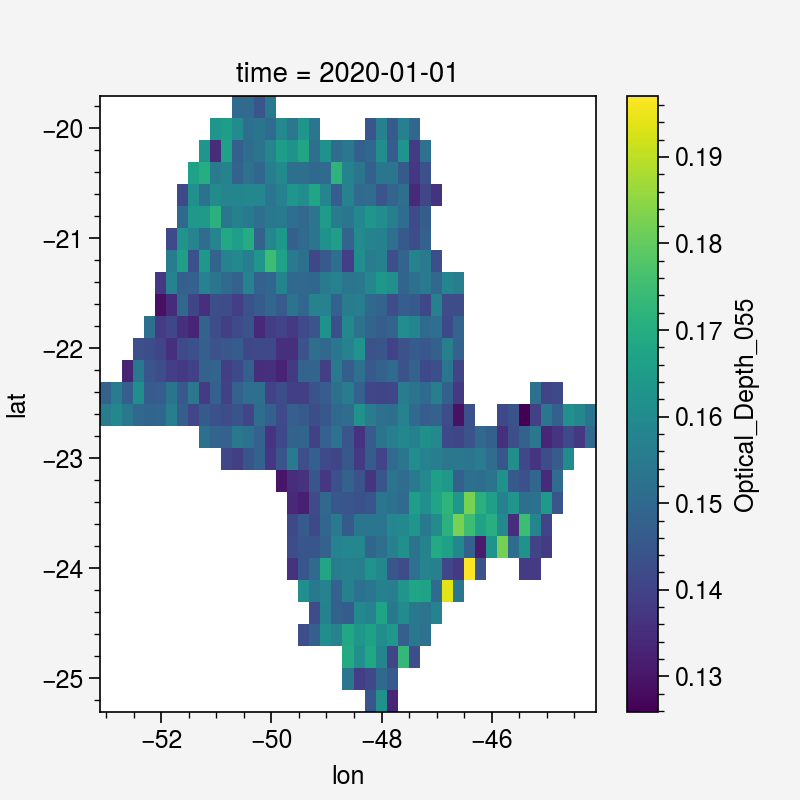

In [19]:
ds.Optical_Depth_055.plot()

### - Para todos os anos

In [ ]:
#========================================================================================================================#
#                                          DATA INICIAL E FINAL
#========================================================================================================================#
data_inicial = '2020-01-01'
data_final = '2025-01-01'

#========================================================================================================================#
#                                          CONFIGURAÇÕES INICIAIS (OTIMIZADO)
#========================================================================================================================#
# Define diretório de saída
output_dir = f'{dir}/output/02_AOD_550nm/'

# Carrega apenas a região de interesse (otimizado)
estado_sp = ee.FeatureCollection('FAO/GAUL/2015/level1') \
              .filter(ee.Filter.eq('ADM1_NAME', 'Sao Paulo')) \
              .first()

#========================================================================================================================#
#                                        FUNÇÃO DE PROCESSAMENTO ANUAL (OTIMIZADA)
#========================================================================================================================#
def processar_exportar_ano(ano):

    """Processa e exporta dados de AOD para um ano específico"""
    try:
        print(f'Processando ano {ano}...')

        # Define intervalo temporal
        inicio_ano = ee.Date.fromYMD(ano, 1, 1)
        fim_ano = inicio_ano.advance(1, 'year')
        print('1. Definiu data inicial e final')

        # Carrega e processa os dados diretamente (mais eficiente)
        AOD_ano = ee.ImageCollection('MODIS/061/MCD19A2_GRANULES') \
                    .filterBounds(estado_sp.geometry()) \
                    .filterDate(inicio_ano, fim_ano) \
                    .select('Optical_Depth_055') \
                    .mean() \
                    .multiply(0.001) \
                    .clip(estado_sp) \
                    .set({'system:time_start': inicio_ano.millis(), 'ano': str(ano)})
        print('2. Carregou os dados')

        # Converte para xarray Dataset (configuração otimizada)
        ds = xr.open_dataset(AOD_ano,
                             engine='ee',
                             crs='EPSG:4326',
                             scale=0.20,
                             geometry=estado_sp.geometry())
        print('3. Transformou para DataSet')

        # Reorganiza dimensões
        ds = ds.transpose("time", "lat", "lon")
        print('4. Calculou a transposta')


        # Nome do arquivo de saída
        output_file = f'{output_dir}AOD_055_MODIS_mean_anual_{ano}_20km.nc'

        # Exporta para NetCDF
        #ds.to_netcdf(output_file)
        print(f'2. Arquivo exportado para netcdf com sucesso: {output_file}')

        return True

    except Exception as e:
        print(f'Erro ao processar ano {ano}: {str(e)}')
        return False

#========================================================================================================================#
#                                        PROCESSAMENTO PRINCIPAL (OTIMIZADO)
#========================================================================================================================#
# Cria lista de anos para processar
anos = np.arange(int(data_inicial[:4]), int(data_final[:4])).tolist()

# Processa cada ano (pode ser paralelizado se necessário)
for ano in anos:

    print('\n#===========================================#')
    print(f' PROCESSANDO ANO {ano} ')
    print('#===========================================#\n')

    success = processar_exportar_ano(ano)

    if not success:
        print(f'Tentando novamente o ano {ano}...')
        processar_exportar_ano(ano)  # Tentativa de recuperação

print('Processamento concluído para todos os anos!')

# **PARTE 2):** Plota painel de figuras - `MAPA DE DENSIDADE`

In [ ]:
# lista dos arquivos mensais. Exemplo: "S5P_co_mensal_2023_11.nc"
files = sorted(glob.glob(f'{dir}/output/03_AOD/AOD_055_mensal_*nc'))

# meses
meses = ['Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez']

# cria a moldura da figura
fig, ax = uplt.subplots(figsize=(18, 12.5), nrows=2, ncols=3, tight=True, proj='pcarree', sharex=True, sharey=True)

# formatação dos eixos
ax.format(coast=False, borders=False, innerborders=False,
          labels=False, latlines=5, lonlines=10,
          latlim=(latmin_MG, latmax_MG), lonlim=(lonmin_MG, lonmax_MG),
          suptitle=f'Aerosol optical depth over land retrieved in the MODIS Green band (0.55 μm)',
          small='20px', large='35px',
          linewidth=0, grid=False)

# loop dos anos
for i, file in enumerate(files):

    # leitura do arquivo netcdf
    ds = xr.open_dataset(file)

    # nome do arquivo
    basename = os.path.basename(os.path.splitext(file)[0])

    # extrai o ano e mês da imagem
    ano, mes = basename[15:19], basename[20:22]

    print('Processando ===>>>',  ano, mes)

    # plota figura
    # opções de palletes: https://proplot.readthedocs.io/en/latest/colormaps.html
    map1 = ax[i].contourf(ds['lon'],
                          ds['lat'],
                          ds['Optical_Depth_055'][0,:,:].salem.roi(shape=mg),
                          cmap='lajolla',
                          vmin=0.0, vmax=0.4,
                          levels=uplt.arange(0.0, 0.4, 0.1),
                          extend='max')

    # total de focos no estado de MG
    total = np.max(ds['Optical_Depth_055'][0,:,:].salem.roi(shape=mg))
    total = round(float(total.values), 1)
    nome_subtitulo = f'{meses[int(mes)-1]}/{ano}={total}'

    # plota titulo de cada figura
    ax[i].format(title=nome_subtitulo, labels = False, titleloc='c', titlecolor='bright blue', fontsize=20)

    # plota contorno de MG e Itajubá
    mg.plot(edgecolor='black', facecolor='none', linewidth=1.2, alpha=1, ax=ax[i])
    itajuba.plot(edgecolor='red', facecolor='none', linewidth=0.5, alpha=1, ax=ax[i])

# informação na figura
ax[3].annotate('Prof. Enrique Mattos/UNIFEI\ngithub.com/evmpython', xy=(lonmin_MG, latmin_MG-4.0), fontsize=15, color='black')

# plota barra de cores da figura
fig.colorbar(map1, loc='b', label='Fonte: AQUA e TERRA/Pixel: 10km', ticks=0.1, ticklabelsize=22, labelsize=22, space=0.5, length=0.60, width=0.4)

# salva figura
fig.savefig(f'{dir}/output/Fig_12_mapa_AOD_055_MG.jpg', transparent=True, dpi=300, bbox_inches="tight", pad_inches=0.1)